# Implementación de una Red Neuronal para Fashion-MNIST

Este documento describe el proceso de implementación de una red neuronal básica desde cero utilizando Python y librerías estándar como NumPy y SciPy para clasificar imágenes del dataset Fashion-MNIST. El objetivo es construir y entrenar una red neuronal de dos capas para reconocer artículos de moda a partir de imágenes en escala de grises.


#### Importamos

Instalamos las bibliotecas necesarias

In [36]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import optimize

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Carga y Preparación de Datos
El dataset Fashion-MNIST consta de imágenes de 28x28 píxeles, cada una asociada a una etiqueta de 10 posibles clases de ropa. Los datos se normalizan dividiendo cada píxel por 255 para que los valores estén entre 0 y 1.

In [35]:
# Cargar los datos de Fashion-MNIST
data_train = pd.read_csv("/content/gdrive/MyDrive/datasets/fashion-mnist_train.csv")
X = data_train.iloc[:, 1:].values / 255.0  # Normalizamos los datos
y = data_train.iloc[:, 0].values

# Cargar los datos de prueba de Fashion-MNIST
data_test = pd.read_csv("/content/gdrive/MyDrive/datasets/fashion-mnist_test.csv")
X_test = data_test.iloc[:, 1:].values / 255.0  # Normalizamos los datos
y_test = data_test.iloc[:, 0].values


# Configurando parámetros necesarios
input_layer_size  = 784  # 28x28 píxeles de entrada
hidden_layer_size = 25   # Número de unidades en la capa oculta
num_labels = 10          # 10 etiquetas, del 0 al 9

#### Visualización de Datos


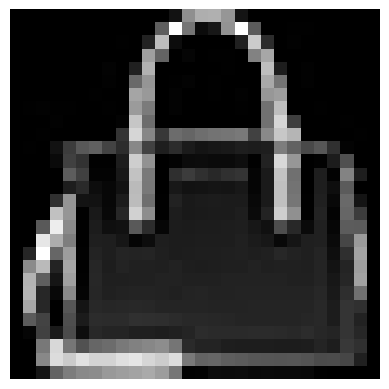

In [38]:
def display_image(img):
    img = img.reshape((28, 28))
    pyplot.imshow(img, cmap='gray')
    pyplot.axis('off')
    pyplot.show()

# Mostrar una imagen aleatoria del dataset
display_image(X[11])

#### Inicialización de Parámetros de la Red
La red tiene una capa oculta y utiliza la inicialización de pesos aleatorios con un rango específico para evitar gradientes demasiado grandes o pequeños durante el entrenamiento.

In [39]:
# Inicialización de pesos
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)


In [40]:
# Desenrollar parámetros
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

##### Definición de la Red y Función de Costo
Implementamos la función sigmoidal como función de activación, y la función de costo incluye un término de regularización para evitar el sobreajuste.

In [41]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))


def sigmoidGradient(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

In [42]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size

    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)

    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    a3 = sigmoid(a2.dot(Theta2.T))

    # print("-"*20)
    # print(y.shape)
    # print(y.reshape(-1))
    # print("-"*20)
    y_matrix = y.reshape(-1)
    # print(y.shape)
    y_matrix = np.eye(num_labels)[y_matrix]
    # print(y_matrix)

    temp1 = Theta1
    temp2 = Theta2

    # Agregar el termino de regularización

    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))

    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term

    # Backpropogation

    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)

    # Agregar regularización al gradiente

    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]

    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]

    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

#### Optimización de Parámetros
Utilizamos scipy.optimize.minimize con el método TNC para entrenar la red, minimizando la función de costo.

In [43]:
# Optimización
options = {'maxfun': 100}  # Limitar a 100 evaluaciones de la función
lambda_ = 1
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
res = optimize.minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)


In [44]:
# Obtener los pesos óptimos
nn_params = res.x
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))


#### Evaluación del Modelo
Después de entrenar el modelo, evaluamos su precisión en el conjunto de entrenamiento.

In [45]:
# Predicción y evaluación de precisión
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    #
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [46]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 80.591667


In [47]:
pred_test = predict(Theta1, Theta2, X_test)
print('Test Set Accuracy: %f' % (np.mean(pred_test == y_test) * 100))


Test Set Accuracy: 80.560000
